### Обучение матриц проекции

Реализуем процесс обучения матриц проекции, который был предложен на SemEval CRIM. Для этого сначала требуется загрузить какие-нибудь эмбеддинги для слов и подобрать то, каких именно кандидатов требуется ранжировать при выдаче гиперонимов.

Начнём с простой стратегии. Возьмём обученную модель FastText и загрузим эмбеддинги из неё. После этого будем для многословных термов усреднять эмбеддинги.

In [1]:
import sys
import json
from os.path import join
import os
sys.path.append("../")
import fasttext as ft
from thesaurus_parsing.thesaurus_parser import ThesaurusParser
from collections import Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
import torch
print(torch.__version__)

1.2.0


In [3]:
deeppavlov_embeddings = ft.load_model('../data/models/fasttext_deeppavlov.bin')

In [4]:
len(deeppavlov_embeddings.get_words())

1572343

Мы видим, что здесь есть векторы для полутора миллионов слов. Конечно же, использовать их все, как кандидаты в гиперонимы, было бы хорошо. Но тем не менее, поскольку метод в основном похож на kNN, это будет очень долго.

Вследствие этого, необходимо, кроме сущностей тезауруса, оставить лишь некоторый топ в качестве кандидатов в гиперонимы. Этот топ можно подобрать по tf-idf. Но для начала надо построить векторы для сущностей из тезауруса.

In [5]:
thesaurus = ThesaurusParser("../data/RuThes", need_closure=False)

In [6]:
vocab_embeddings = dict()

In [7]:
for _, entry_dict in thesaurus.text_entries.items():
    lemma = entry_dict['lemma']
    vocab_embeddings[lemma] = deeppavlov_embeddings.get_sentence_vector(lemma)

In [8]:
len(vocab_embeddings)

110176

Давайте пройдём по всем текстам, которые загрузились на данный момент, для слов, которые есть в словаре, посчитаем частоту слов

In [8]:
DIR_PATH = "/home/loginov-ra/MIPT/HypernymyDetection/data/Lenta/texts_tagged_processed_tree"
file_list = os.listdir(DIR_PATH)
file_list = [join(DIR_PATH, filename) for filename in file_list]

In [9]:
word_ctr = Counter()
no_deeppavlov = 0

for filename in tqdm(file_list):
    with open(filename, encoding='utf-8') as sentences_file:
        sentences = json.load(sentences_file)
        for sent in sentences:
            if 'deeppavlov' not in sent:
                no_deeppavlov += 1
                continue
            
            multitokens, _ = sent['multi']
            for t in multitokens:
                word_ctr[t] += 1

In [10]:
print(no_deeppavlov)

883


In [11]:
word_ctr.most_common(n=28)

[(',', 521733),
 ('.', 445009),
 ('в', 307206),
 ('"', 299914),
 ('на', 125625),
 ('и', 123598),
 ('-', 111278),
 ('с', 77467),
 ('что', 72277),
 ('быть', 70839),
 ('по', 70425),
 ('год', 57392),
 ('о', 52364),
 (')', 49128),
 ('(', 48432),
 ('не', 47363),
 ('который', 42268),
 ('он', 40684),
 (':', 40304),
 ('это', 37290),
 ('из', 37212),
 ('тот', 32196),
 ('за', 28677),
 ('как', 28572),
 ('один', 27042),
 ('--', 26014),
 ('к', 23407),
 ('сообщать', 22883)]

Видим, что для первых $27$ слов нет необходимости искать гиперонимы, для остальных уже может быть. Поэтому возьмёи пока первые $100000$ слов для работы с ними, посчитаем их эмбеддинги и добавим в словарь.

In [12]:
additional_words = word_ctr.most_common(n=100000)[27:]

In [13]:
for word, _ in additional_words:
    vocab_embeddings[word] = deeppavlov_embeddings.get_word_vector(word)

Удалим модель за ненадобностью

In [14]:
del deeppavlov_embeddings

In [15]:
len(vocab_embeddings)

172251

Видим, что было пересечение, и добавилась где-то 61000 слов
_________________

**Определение модели**

Определим модель, в которой будет 5 матриц проекции и логистическая регрессия на косинусных расстояниях до проекций.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
device

'cpu'

In [13]:
class CRIMModel(nn.Module):
    def __init__(self, n_matrices=5, embedding_dim=300, init_sigma=0.01):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_matrices = n_matrices
        self.init_sigma = init_sigma
        
        matrix_shape = (n_matrices, 1, embedding_dim, embedding_dim)
        self.matrices = torch.FloatTensor(size=matrix_shape)
        self.prob_layer = nn.Linear(in_features=n_matrices, out_features=1)
        
        for i in range(n_matrices):
            eye_tensor = torch.FloatTensor(size=(embedding_dim, embedding_dim), device=device)
            noise_tensor = torch.FloatTensor(size=(embedding_dim, embedding_dim), device=device)
            torch.nn.init.eye_(eye_tensor)
            torch.nn.init.normal_(noise_tensor, std=init_sigma)
            self.matrices[i][0] = eye_tensor + noise_tensor
            
        torch.nn.init.normal_(self.prob_layer.weight, std=0.1)
        self.matrices = nn.Parameter(self.matrices.requires_grad_())
        
    def forward(self, input_dict):
        candidate = input_dict['candidate']
        candidate_batch = candidate.shape[0]
        candidate = candidate.view((candidate_batch, 1, self.embedding_dim))
        batch = input_dict['batch'].unsqueeze(-1)
        
        print('Batch')
        print(batch)
        
        print('Matrices')
        print(model.matrices)
        
        batch_size = batch.shape[0]
        projections = torch.matmul(self.matrices, batch).permute(1, 0, 2, 3).squeeze(-1)
        
        print('Projections')
        print(projections)
        
        similarities = F.cosine_similarity(projections, candidate, dim=-1)
        
        print('Similarities')
        print(similarities)
        
        logits = self.prob_layer(similarities)
        
        print('Logits')
        print(logits)
        
        return logits

In [14]:
model = CRIMModel(n_matrices=10)

In [197]:
args = {
    'batch': torch.randn(64, 300),
    'candidate': torch.randn(1, 300)
}

In [321]:
torch.set_printoptions(precision=10)
model(args) + 0.00001

Batch
tensor([[[ 0.7252664566],
         [-0.8776559830],
         [ 0.1537696570],
         ...,
         [ 0.6769005060],
         [ 1.9011576176],
         [-0.3448872566]],

        [[ 0.3573443890],
         [ 1.1088384390],
         [ 0.3916432261],
         ...,
         [ 0.9089306593],
         [-0.0138565507],
         [-0.2266946733]],

        [[-1.6157082319],
         [ 0.4387985170],
         [-2.3074474335],
         ...,
         [-0.3596394658],
         [-0.1646138281],
         [-1.9526571035]],

        ...,

        [[-0.2422087938],
         [-0.5033995509],
         [-0.8423961997],
         ...,
         [-0.0900238976],
         [-0.2999053299],
         [-0.2994983494]],

        [[ 0.6062324047],
         [-2.6377589703],
         [ 2.6361970901],
         ...,
         [-1.3261247873],
         [ 0.9108996391],
         [ 1.2913289070]],

        [[-0.6621691585],
         [-0.6577079296],
         [ 0.4029124081],
         ...,
         [ 0.3069745600],
  

tensor([[0.9999791384],
        [0.9999576807],
        [0.9999443293],
        [0.9999525547],
        [0.9999434948],
        [0.9999697208],
        [0.9999523163],
        [0.9999678135],
        [0.9999654293],
        [0.9999561310],
        [0.9999734163],
        [0.9999630451],
        [0.9999340773],
        [0.9999167919],
        [0.9999330044],
        [0.9999717474],
        [0.9999766350],
        [0.9999618530],
        [0.9999479055],
        [0.9999459982],
        [0.9999866486],
        [0.9999510050],
        [0.9999728203],
        [0.9999634027],
        [0.9999434948],
        [0.9999754429],
        [0.9999580383],
        [0.9999631643],
        [0.9999715090],
        [0.9999673367],
        [0.9999231100],
        [0.9999569654],
        [0.9999526739],
        [0.9999637604],
        [0.9999693632],
        [0.9999608994],
        [0.9999630451],
        [0.9999397993],
        [0.9999629259],
        [0.9999576807],
        [0.9999662638],
        [0.99998

In [118]:
optimizer = Adam(model.parameters(), lr=1)

In [25]:
while True:
    probas = model(args)
    loss = probas.sum()
    print('Loss:', loss.detach().numpy())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Loss: 17.964901
Loss: 12.851678
Loss: 3.3438678
Loss: 0.95996743
Loss: 0.34611475
Loss: 0.15378752
Loss: 0.08027104
Loss: 0.047051396
Loss: 0.029958203
Loss: 0.020270685
Loss: 0.014373403
Loss: 0.010583589
Loss: 0.00804223
Loss: 0.0062779696
Loss: 0.0050170803
Loss: 0.0040932065
Loss: 0.0034014245
Loss: 0.002873423
Loss: 0.0024635247
Loss: 0.002140436
Loss: 0.0018822715
Loss: 0.0016734287
Loss: 0.0015025898
Loss: 0.0013614183
Loss: 0.0012436841
Loss: 0.0011446679
Loss: 0.0010607538
Loss: 0.0009891376
Loss: 0.0009276207
Loss: 0.00087446626
Loss: 0.0008282855
Loss: 0.0007879608
Loss: 0.0007525835
Loss: 0.000721412
Loss: 0.00069383346
Loss: 0.0006693418
Loss: 0.00064751366
Loss: 0.00062799256
Loss: 0.0006104789
Loss: 0.0005947185
Loss: 0.0005804937
Loss: 0.00056761847
Loss: 0.0005559328
Loss: 0.00054529915
Loss: 0.0005355967
Loss: 0.0005267216
Loss: 0.000518582
Loss: 0.000511099
Loss: 0.00050420145
Loss: 0.0004978282
Loss: 0.0004919249
Loss: 0.00048644276
Loss: 0.00048133967
Loss: 0.00047

Loss: 0.00016356644
Loss: 0.00016328531
Loss: 0.00016300507
Loss: 0.00016272582
Loss: 0.00016244744
Loss: 0.00016217011
Loss: 0.0001618936
Loss: 0.00016161801
Loss: 0.00016134337
Loss: 0.00016106965
Loss: 0.00016079679
Loss: 0.00016052487
Loss: 0.00016025393
Loss: 0.00015998397
Loss: 0.00015971485
Loss: 0.00015944662
Loss: 0.00015917922
Loss: 0.00015891276
Loss: 0.00015864713
Loss: 0.00015838242


KeyboardInterrupt: 

Во всяком случае, на текущий момент возможно переобучить модель под нужные значения
_________________

**Цикл обучения модели**

Для того, чтобы обучить модель, надо сделать следующие шаги:

* Добавить пары корректных гипонимов-гиперонимов
* Для каждого положительного добавить несколько отрицательных (пока просто случайные слова)
* Добавить вектор правильных ответов

Сделаем из этого `torch.Dataset`

In [15]:
class HypernymQueriesDataset(Dataset):
    def load_train_items(self, thesaurus, vocab, train_keys):
        self.train_items = []
        for hyponym in tqdm(train_keys):
            hypernyms = thesaurus.hypernyms_dict[hyponym]
            for hypernym in hypernyms:
                self.train_items.append([hyponym, hypernym, True])
            
            negative_examples = np.random.choice(list(vocab.keys()), size=self.n_negative * len(hypernyms))
            for negative in negative_examples:
                self.train_items.append([hyponym, negative, False])
                
            if self.max_pairs is not None and len(self.train_items) > self.max_pairs:
                break
    
    def __init__(self, thesaurus, vocab, train_keys, n_negative=3, max_pairs=None):
        self.n_negative = n_negative
        self.thesaurus = thesaurus
        self.vocab = vocab
        self.max_pairs = max_pairs
        
        self.load_train_items(thesaurus, vocab, train_keys)
        
    def __len__(self):
        return len(self.train_items)
    
    def __getitem__(self, idx):
        hyponym, hypernym, label = self.train_items[idx]
        return (self.vocab[hyponym], self.vocab[hypernym], label)

In [16]:
with open('train_keys') as train_file:
    train_keys = train_file.readlines()
train_keys = [key[:-1] if key[-1] == '\n' else key for key in train_keys]

In [19]:
dataset = HypernymQueriesDataset(thesaurus, vocab_embeddings, train_keys, max_pairs=300)

Создадим ещё тестовый датасет, чтобы проверять качество на нём во время обучения. Пока будем смотреть только на функцию ошибки.

In [20]:
with open('test_keys') as test_file:
    test_keys = test_file.readlines()
test_keys = [key[:-1] if key[-1] == '\n' else key for key in test_keys]

In [21]:
test_dataset = HypernymQueriesDataset(thesaurus, vocab_embeddings, test_keys, max_pairs=100)

In [22]:
model = CRIMModel(n_matrices=1)
optimizer = Adam(model.parameters(), lr=3e-3)
n_epochs = 1
batch_size = 64
plot_frequency = 50
val_freq = 1000
loss_fn = nn.BCEWithLogitsLoss()

In [23]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [24]:
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True)
for b in test_loader:
    test_batch = b
    break

In [25]:
def eval_loss_on_test(model):
    model.eval()
    hyponyms, candidates, labels = test_batch
    model_batch = {
        'batch': hyponyms,
        'candidate': candidates
    }
    labels = labels.float()
    logits = model(model_batch).squeeze()
    loss = loss_fn(logits, labels)
    return loss.detach().numpy()

In [26]:
loss_history = []
test_loss_history = []
matrix_norms = []
weight_norms = []

In [28]:
for epoch in range(n_epochs):
    print('Epoch {}. Started training.'.format(epoch + 1))

    for it, batch in tqdm(enumerate(data_loader), total=len(dataset) / batch_size):
        model.train()
        hyponyms, candidates, labels = batch
        
        print(hyponyms.shape)
        
        model_batch = {
            'batch': hyponyms,
            'candidate': candidates
        }

        labels = labels.float()
        logits = model(model_batch).squeeze()
        loss = loss_fn(logits, labels)
        
        if np.isnan(loss.detach().numpy()):
            print(probas)
            break
        
        if len(loss_history) % val_freq == 0:
            test_loss_history.append(eval_loss_on_test(model))
        loss_history.append(loss.detach().numpy())
        matrix_norm = np.linalg.norm(model.matrices.detach().numpy())
        matrix_norms.append(matrix_norm)
        weight_norm = np.linalg.norm(model.prob_layer.weight.detach().numpy())
        weight_norms.append(weight_norm)
        
        if len(loss_history) % plot_frequency == 0:
            print(loss)
            clear_output(wait=True)
            plt.figure(figsize=(20, 7))
            
            plt.subplot(1, 2, 1)
            plt.title('Loss history', fontsize=18)
            plt.xlabel('Iteration', fontsize=15)
            plt.ylabel('CE loss', fontsize=15)
            plt.plot(np.array(loss_history), label='train')
            plt.plot(np.arange(len(test_loss_history)) * val_freq, np.array(test_loss_history), label='test')
            plt.legend(fontsize=15)
            
            plt.subplot(1, 2, 2)
            plt.title('Matrix norm history', fontsize=18)
            plt.xlabel('Iteration', fontsize=15)
            plt.ylabel('L2 Norm', fontsize=15)
            plt.plot(np.array(matrix_norms))
            plt.plot(np.array(weight_norms))
            
            plt.show()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        print('Matrix grad')
        print(model.matrices.grad)
        
        optimizer.step()
        optimizer.zero_grad()

Epoch 1. Started training.


torch.Size([64, 300])
Batch
tensor([[[ 0.0261],
         [ 0.0979],
         [-0.0401],
         ...,
         [-0.0251],
         [-0.0500],
         [-0.0133]],

        [[-0.0273],
         [-0.0372],
         [-0.0413],
         ...,
         [-0.0141],
         [ 0.0174],
         [-0.0078]],

        [[ 0.0261],
         [ 0.0979],
         [-0.0401],
         ...,
         [-0.0251],
         [-0.0500],
         [-0.0133]],

        ...,

        [[ 0.0261],
         [ 0.0979],
         [-0.0401],
         ...,
         [-0.0251],
         [-0.0500],
         [-0.0133]],

        [[ 0.0261],
         [ 0.0979],
         [-0.0401],
         ...,
         [-0.0251],
         [-0.0500],
         [-0.0133]],

        [[ 0.0229],
         [-0.0117],
         [-0.0763],
         ...,
         [ 0.0146],
         [ 0.0227],
         [-0.0775]]])
Matrices
Parameter containing:
tensor([[[[ 1.0217e+00, -1.3330e-02,  3.5254e-03,  ..., -4.1922e-04,
            2.1876e-02,  9.6231e-03],
    

In [351]:
torch.save(model.state_dict(), '../data/models/projection_model_single.bin')

In [335]:
clamped

tensor([0.999999523162842, 0.999998688697815, 0.999999761581421,
        0.999999046325684, 0.999999880790710, 0.999999523162842,
        0.999999284744263, 0.999999642372131, 0.999999403953552,
        0.999999761581421, 0.999999165534973, 0.999998927116394,
        1.000000000000000, 0.999999165534973, 0.999997735023499,
        0.999998688697815, 0.999999284744263, 0.999998927116394,
        0.999998569488525, 0.999999284744263, 0.999999284744263,
        0.999999642372131, 0.999999523162842, 0.999998688697815,
        0.999999165534973, 0.999998450279236, 0.999999523162842,
        0.999999761581421, 0.999999523162842, 0.999999403953552,
        0.999999642372131, 0.999999284744263, 0.999998569488525,
        0.999999523162842, 0.999999761581421, 0.999999046325684,
        0.999999284744263, 0.999999761581421, 0.999999523162842,
        0.999999523162842, 0.999999523162842, 0.999999761581421,
        0.999999642372131, 0.999999761581421, 0.999997854232788,
        0.999999642372131

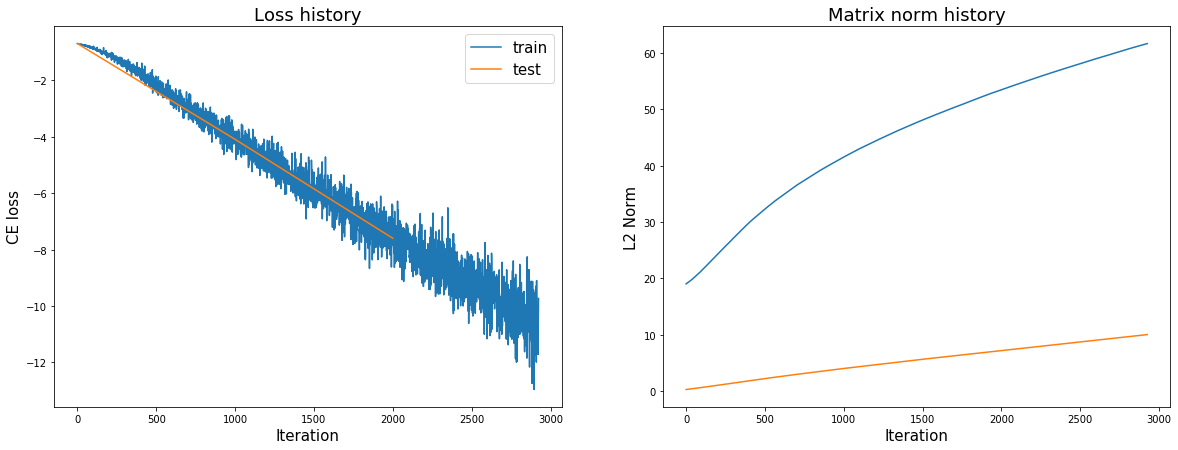

In [305]:
plt.figure(figsize=(20, 7))
            
plt.subplot(1, 2, 1)
plt.title('Loss history', fontsize=18)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('CE loss', fontsize=15)
plt.plot(np.array(loss_history), label='train')
plt.plot(np.arange(len(test_loss_history)) * val_freq, np.array(test_loss_history), label='test')
plt.legend(fontsize=15)
           
plt.subplot(1, 2, 2)
plt.title('Matrix norm history', fontsize=18)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('L2 Norm', fontsize=15)
plt.plot(np.array(matrix_norms))
plt.plot(np.array(weight_norms))

In [306]:
weight_norms[-10:]

[10.003188,
 10.006206,
 10.009219,
 10.012233,
 10.015238,
 10.01826,
 10.021319,
 10.0243845,
 10.027425,
 10.030435]

In [309]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]]], requires_grad=True)
Parameter containing:
tensor([[nan]], requires_grad=True)
Parameter containing:
tensor([nan], requires_grad=True)


In [310]:
loss_history[-10:]

[array(-11.564904, dtype=float32),
 array(-10.748442, dtype=float32),
 array(-10.634823, dtype=float32),
 array(-10.231451, dtype=float32),
 array(-11.301371, dtype=float32),
 array(-11.715054, dtype=float32),
 array(-10.933878, dtype=float32),
 array(-10.134322, dtype=float32),
 array(-9.730699, dtype=float32),
 array(-inf, dtype=float32)]